## EPOCH 200, BATCH 100, SIGN TYPE CLASSIFICATION

In [1]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

import pandas as pd

In [2]:
from PIL import Image
import glob
image_list = []

for filepath in glob.glob('trafficsigns_dataset1/*/*.png', recursive=True): 
    filename = filepath.split("\\")[0]
    signType = filepath.split("\\")[-2]
    image_list.append((filepath, signType))
        
# Create a data frame
data = pd.DataFrame(data=image_list, columns=['image_path', 'signType'])

#Convert shape labels to integers
d = {'bicycle':0,'continue':1,'crossing':2,'giveway':3, 'laneend':4, 'limitedtraffic':5,'noentry':6, 'noparking':7,
     'parking':8,'rightofway':9,'roundabout':10,'speed':11, 'stop':12, 'trafficdirective':13,'traveldirection':14, 
     'warning':15}
data['type_num'] = data['signType'].map(d, na_action='ignore')

In [3]:
#Generate train/test sets
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2)

In [4]:
from tensorflow.keras import regularizers, optimizers
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

In [5]:
def calculate_losses(model_, data_generator_, N_images, batch_size_):
    loss_hold = []
    acc_hold = []
    batches = 0
    for x,y in data_generator_:
        loss,acc = model_.evaluate(x, y, verbose=0)
        loss_hold.append(loss)
        acc_hold.append(acc)
        batches += 1
        if batches >= N_images / batch_size_:
            break
        return np.mean(loss_hold), np.mean(acc_hold)

In [6]:
def train_model(model_, train_generator_in, validation_generator_in, num_epoch=200, verbose=False):
    res = []
    for e in range(num_epoch): 
        print('Epoch', e)
        batches = 0

        loss_ = []
        acc_ = []
        for x,y in train_generator_in:
            loss, acc = model_.train_on_batch(x, y) 
            loss_.append(loss)
            acc_.append(acc)
            batches += 1
            if batches >= train.shape[0] / batch_size:
                break
        loss_ = np.mean(loss_)
        acc_ = np.mean(acc_)
        print("Training epoch {}: Loss = {}, Accuracy = {}".format(e, loss_, acc_))

        loss, acc = calculate_losses(model_, validation_generator_in, test.shape[0], batch_size)
        print("Validation epoch {}: Loss = {}, Accuracy = {}".format(e, loss, acc))

        res.append((e, loss_, acc_, loss, acc))
    return np.asarray(res)

In [7]:
def plot_results(res):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(res[:,0], res[:,1], 'r-')
    plt.plot(res[:,0], res[:,3], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.ylim([0, np.max([5., np.max(res[:,1]), np.max(res[:,3])])])

    plt.subplot(1,2,2)
    plt.plot(res[:,0], res[:,2], 'r-')
    plt.plot(res[:,0], res[:,4], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, np.max([1., np.max(res[:,2]), np.max(res[:,4])])])

## Pre Process

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last', 
                                   rotation_range=15, width_shift_range=0.2, 
                                   height_shift_range=0.2)
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 100

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train,
        directory='./',
        x_col="image_path",
        y_col="signType",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=test,
        directory='./',
        x_col="image_path",
        y_col="signType",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

Found 2959 validated image filenames belonging to 16 classes.
Found 740 validated image filenames belonging to 16 classes.


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import categorical_accuracy

model_cnn = Sequential()
model_cnn.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001), input_shape=(28, 28, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Conv2D(64, (3, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Flatten())  
model_cnn.add(Dense(64))
model_cnn.add(Activation('relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(16))
model_cnn.add(Activation('softmax'))

model_cnn.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])

model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 11, 11, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          1

In [10]:
res = train_model(model_cnn, train_generator, validation_generator, num_epoch=200, verbose=False)

Epoch 0
Training epoch 0: Loss = 2.719904311498006, Accuracy = 0.1556497186422348
Validation epoch 0: Loss = 2.6537370681762695, Accuracy = 0.1899999976158142
Epoch 1
Training epoch 1: Loss = 2.6475457270940144, Accuracy = 0.18888135602076847
Validation epoch 1: Loss = 2.6687281131744385, Accuracy = 0.12999999523162842
Epoch 2
Training epoch 2: Loss = 2.620335515340169, Accuracy = 0.1923531065384547
Validation epoch 2: Loss = 2.5255281925201416, Accuracy = 0.12999999523162842
Epoch 3
Training epoch 3: Loss = 2.5979785839716594, Accuracy = 0.19488983005285263
Validation epoch 3: Loss = 2.552868366241455, Accuracy = 0.10999999940395355
Epoch 4
Training epoch 4: Loss = 2.5487962563832602, Accuracy = 0.20986440777778625
Validation epoch 4: Loss = 2.460446357727051, Accuracy = 0.1599999964237213
Epoch 5
Training epoch 5: Loss = 2.480335235595703, Accuracy = 0.22907627274592718
Validation epoch 5: Loss = 2.301642656326294, Accuracy = 0.3499999940395355
Epoch 6
Training epoch 6: Loss = 2.4125

Training epoch 51: Loss = 0.5125088592370352, Accuracy = 0.8657118598620097
Validation epoch 51: Loss = 0.4104915261268616, Accuracy = 0.949999988079071
Epoch 52
Training epoch 52: Loss = 0.5532430350780487, Accuracy = 0.8512853105862935
Validation epoch 52: Loss = 0.3917868435382843, Accuracy = 0.9200000166893005
Epoch 53
Training epoch 53: Loss = 0.5161231438318888, Accuracy = 0.8679802219072977
Validation epoch 53: Loss = 0.19451270997524261, Accuracy = 0.9700000286102295
Epoch 54
Training epoch 54: Loss = 0.4984007130066554, Accuracy = 0.8651836136976878
Validation epoch 54: Loss = 0.23601782321929932, Accuracy = 0.9300000071525574
Epoch 55
Training epoch 55: Loss = 0.47045058012008667, Accuracy = 0.8780084768931071
Validation epoch 55: Loss = 0.16278140246868134, Accuracy = 0.9750000238418579
Epoch 56
Training epoch 56: Loss = 0.4882906456788381, Accuracy = 0.8665601273377737
Validation epoch 56: Loss = 0.1520175039768219, Accuracy = 0.9800000190734863
Epoch 57
Training epoch 57: 

Training epoch 102: Loss = 0.3136459653576215, Accuracy = 0.9265734533468882
Validation epoch 102: Loss = 0.14771026372909546, Accuracy = 0.9700000286102295
Epoch 103
Training epoch 103: Loss = 0.3262451579173406, Accuracy = 0.9250367263952891
Validation epoch 103: Loss = 0.23445501923561096, Accuracy = 0.949999988079071
Epoch 104
Training epoch 104: Loss = 0.31476549953222277, Accuracy = 0.929257466395696
Validation epoch 104: Loss = 0.2761708199977875, Accuracy = 0.9399999976158142
Epoch 105
Training epoch 105: Loss = 0.3105977366367976, Accuracy = 0.9289435048898061
Validation epoch 105: Loss = 0.08591930568218231, Accuracy = 1.0
Epoch 106
Training epoch 106: Loss = 0.28256659309069315, Accuracy = 0.9299717525641124
Validation epoch 106: Loss = 0.13335327804088593, Accuracy = 0.9900000095367432
Epoch 107
Training epoch 107: Loss = 0.29152477979660035, Accuracy = 0.9314067840576172
Validation epoch 107: Loss = 0.24846120178699493, Accuracy = 0.9800000190734863
Epoch 108
Training epoc

Training epoch 152: Loss = 0.22247346291939418, Accuracy = 0.951549643278122
Validation epoch 152: Loss = 0.13390187919139862, Accuracy = 0.9800000190734863
Epoch 153
Training epoch 153: Loss = 0.25035602500041326, Accuracy = 0.9450734476248424
Validation epoch 153: Loss = 0.25397175550460815, Accuracy = 0.9800000190734863
Epoch 154
Training epoch 154: Loss = 0.2365295042594274, Accuracy = 0.9499717553456625
Validation epoch 154: Loss = 0.1195085421204567, Accuracy = 0.9800000190734863
Epoch 155
Training epoch 155: Loss = 0.25867894987265266, Accuracy = 0.945841807126999
Validation epoch 155: Loss = 0.19855491816997528, Accuracy = 0.9700000286102295
Epoch 156
Training epoch 156: Loss = 0.248581600189209, Accuracy = 0.9460084776083628
Validation epoch 156: Loss = 0.11400451511144638, Accuracy = 0.9800000190734863
Epoch 157
Training epoch 157: Loss = 0.22338840315739314, Accuracy = 0.9564999997615814
Validation epoch 157: Loss = 0.33718112111091614, Accuracy = 0.949999988079071
Epoch 158

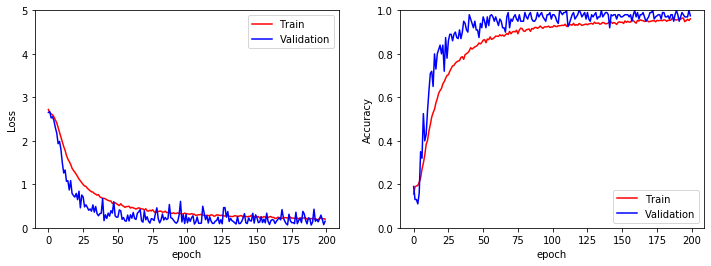

In [11]:
plot_results(res)

## Independent evaluation

In [24]:
#load images into dataset
images = []

for filepath in glob.glob('ind_eval/type/*/*', recursive=True): 
    typeSign = filepath.split("\\")[-2]
    images.append((filepath, typeSign))

ie = pd.DataFrame(data=images, columns=['image_path', 'type'])

In [25]:
#Pre process images
datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size_t = 1

ie_generator = datagen.flow_from_dataframe(
        dataframe=ie,
        directory='./',
        x_col="image_path",
        y_col="type",
        target_size=(28, 28),
        batch_size=batch_size_t,
        class_mode='categorical')


Found 80 validated image filenames belonging to 16 classes.


## Predict On Images from External Sources

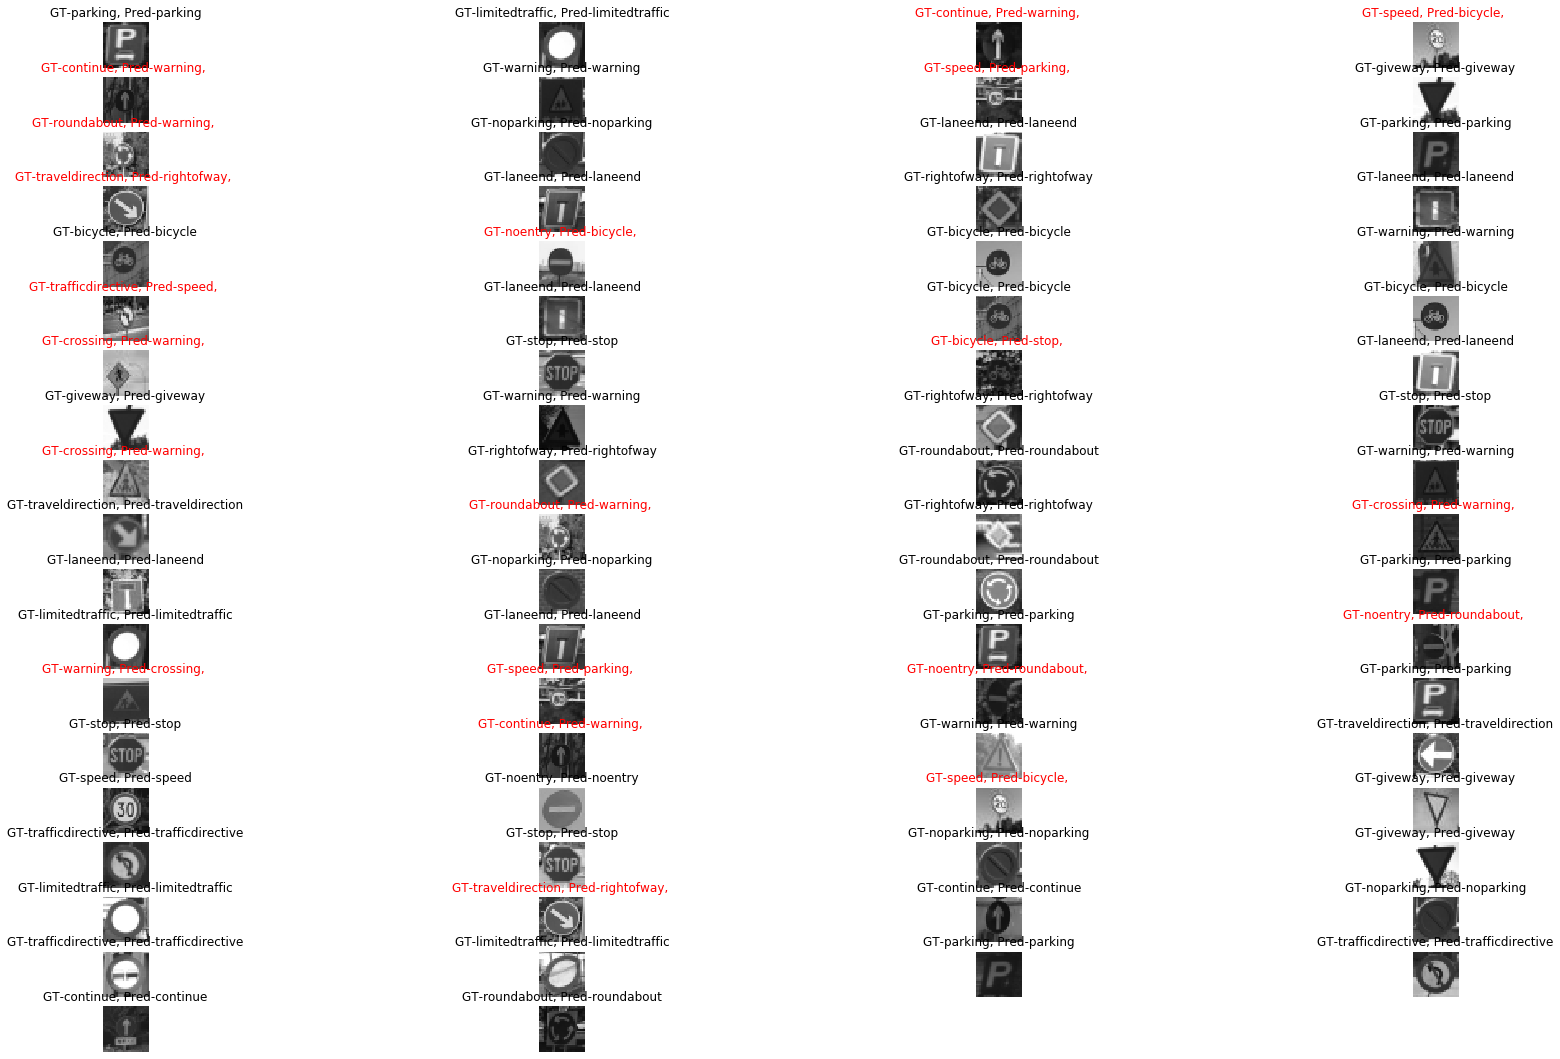

In [29]:
d_inv = {v: k for k, v in d.items()}
plt.figure(figsize=(30,30))
batches = 0
incorrect = 0
for x,y in ie_generator:
        batches = batches + 1
        y_hat = model_cnn.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 75:
            plt.subplot(30,4,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            if d_inv[np.argmax(y[0])] != d_inv[np.argmax(y_hat[0])]:
                plt.title("GT-{}, Pred-{}, ".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])]), color = 'r') 
                incorrect = incorrect + 1
        else:
            break
        
        plt.axis('off')

In [31]:
print("Number of incorrect predictions: ", incorrect, "out of 100")

Number of incorrect predictions:  20 out of 100
